In [4]:
import pandas as pd
import numpy as np
base_line_data = pd.read_csv("../DBtrainrides_final_result.csv")
# Drop all delay based features except for the target variable arrival_delay_m
base_line_data.drop(columns=["arrival_plan","departure_plan","prev_arrival_delay_m","prev_departure_delay_m", "weighted_avg_prev_delay"],inplace=True)

# Encode info_messages
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']

base_line_data['transformed_info_message'] = pd.Categorical(
    base_line_data['transformed_info_message'],
    categories=message_order,
    ordered=True
)
base_line_data['transformed_info_message'] = base_line_data['transformed_info_message'].cat.codes

# Fill arrival_delay_m NaN values with 0
base_line_data["arrival_delay_m"] = base_line_data["arrival_delay_m"].fillna(0.0)
# Step 1: Create a unique identifier for groups
base_line_data['Group'] = base_line_data['ID_Base'].astype(str) + "_" + base_line_data['ID_Timestamp'].astype(str)

# Step 2: Get unique groups and shuffle them
unique_groups = base_line_data['Group'].unique()
np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_groups)

# Step 3: Split groups into train and test
split_idx = int(0.8 * len(unique_groups))  # 80-20 split
train_groups = unique_groups[:split_idx]
test_groups = unique_groups[split_idx:]

# Step 4: Assign rows to train and test sets
train_data = base_line_data[base_line_data['Group'].isin(train_groups)]
test_data = base_line_data[~base_line_data['Group'].isin(train_groups)]

# Step 5: Get train and test targets
train_target = train_data["arrival_delay_m"]
test_target = test_data["arrival_delay_m"]

# Drop the helper column if necessary
train_data = train_data.drop(columns=['Group','arrival_delay_m'])
test_data = test_data.drop(columns=['Group', 'arrival_delay_m'])
train_data


,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,transformed_info_message,max_station_number,station_progress
0,-1001326572688500578,2407082041,2,8011118.0,13.375988,52.509379,0,7,0.285714
1,-1001326572688500578,2407082041,3,8011160.0,9.095851,48.849792,0,7,0.428571
2,-1001326572688500578,2407082041,4,8011167.0,13.299437,52.530276,0,7,0.571429
3,-1001326572688500578,2407082041,5,8010404.0,13.196898,52.534648,0,7,0.714286
4,-1001326572688500578,2407082041,6,8080040.0,13.128917,52.549396,0,7,0.857143
...,...,...,...,...,...,...,...,...,...
2430246,999976718847540977,2407100447,6,8005649.0,7.110814,49.274763,0,6,1.000000
2430247,999976718847540977,2407120447,2,8005241.0,7.018788,49.230425,0,6,0.333333
2430248,999976718847540977,2407120447,3,8005306.0,8.243728,50.070788,0,6,0.500000
2430249,999976718847540977,2407120447,4,8005332.0,7.057083,49.244018,0,6,0.666667


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
df_features_train_scaled = scaler.fit_transform(train_data)
train_target_scaled = scaler.fit_transform(train_target.values.reshape(-1, 1))

# Convert back to a pandas Series if needed
train_target_scaled = pd.Series(train_target_scaled.flatten())

regression_tree = DecisionTreeRegressor()
# Train on scaled data
regression_tree.fit(df_features_train_scaled, train_target)

# Predict on the test data
test_predictions = regression_tree.predict(test_data)

# Calculate Mean Squared Error as a performance metric
mse = mean_squared_error(test_target, test_predictions)
mae = mean_absolute_error(test_target, test_predictions)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Mean Squared Error: 8.003450359220416
# Mean Absolute Error: 1.0899843909791496
# Worse than predicting the average delay in the dataset

Mean Squared Error: 8.003450359220416
Mean Absolute Error: 1.0899843909791496


C:\Users\rapha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


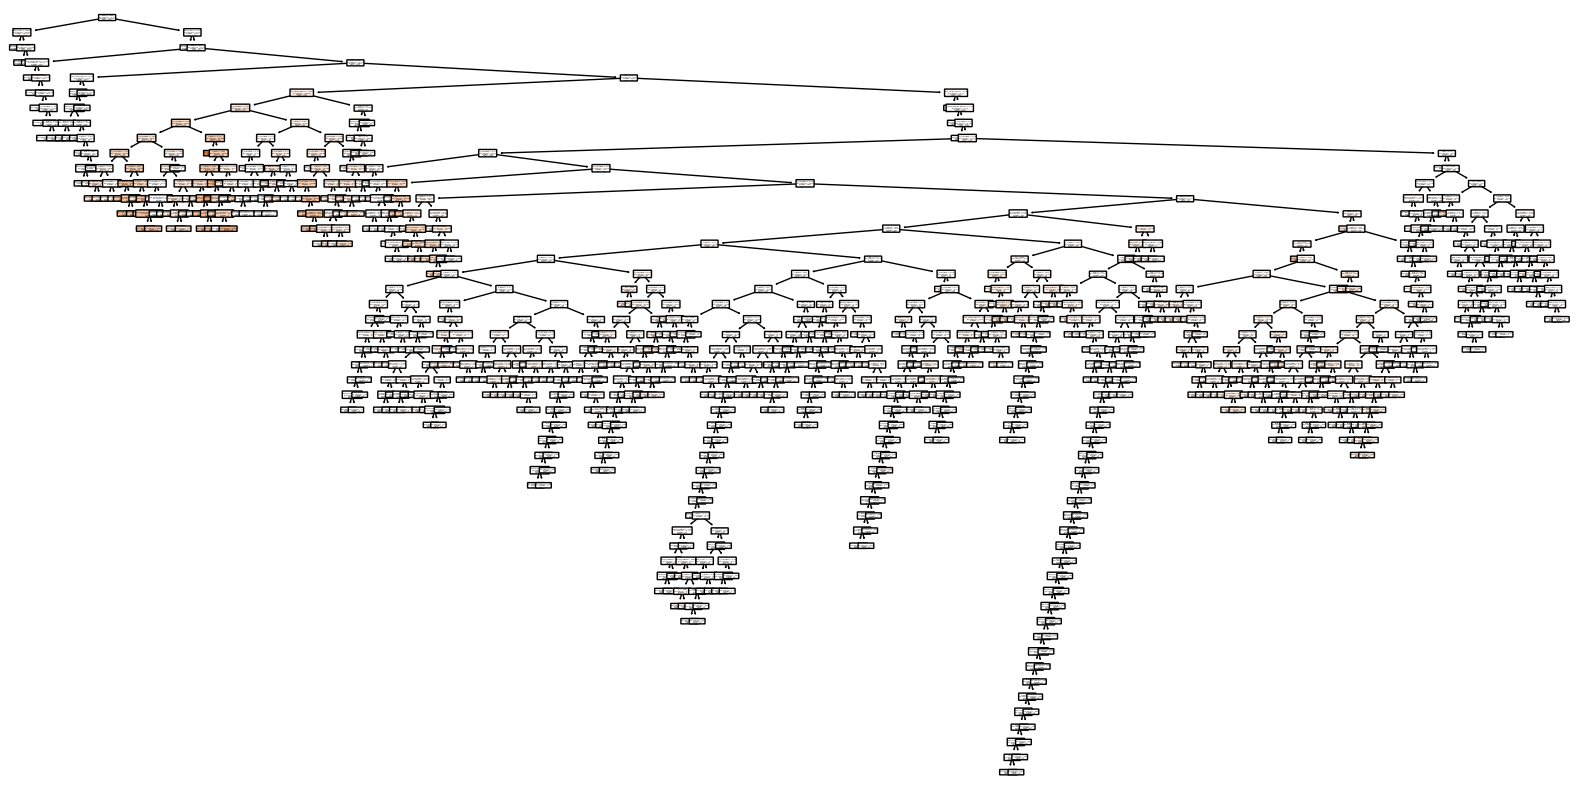

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=train_data.columns, filled=True, rounded=True)
plt.show()
